In [1]:
import ase.io
import structure_tools as ST
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%ls 

activation_energy_amo_cryst.png*  msd_amo_473.txt*
activation_energy_amo.png*        msd_amo_523.png*
activation_energy_cryst.png*      msd_amo_523.txt*
amo_723_all.gif*                  msd_amo_573.png*
amo_723.gif*                      msd_amo_573.txt*
amo_activation.png*               msd_amo_623.png*
amorphous_diffuse.png*            msd_amo_623.txt*
analyse-bonding.ipynb*            msd_amo_723.png*
animation_amorphous.mp4*          msd_amo_723.txt*
cluster_analysis.py*              msd_crst_473.txt*
cluster.png*                      msd_cryt_473.png*
count_bond_ovito.py*              msd_cryt_523.png*
cryst_activation.png*             msd_cryt_573.png*
crystal_723_all.gif*              msd_cryt_573.txt*
crystal_723.gif*                  msd_cryt_623.png*
diff_quench_2/                    msd_cryt_723.png*
diffusion_cryst_amo_1.png*        msd_cryt_723.txt*
diffusion_cryst_amo.png*          MSD_diffusion_ovito.ipynb*
dump_amo_723.out*                 new_calculations/
dump_cry_723

In [3]:
%ls dump_amo_723.out

dump_amo_723.out*


In [4]:
symbol_map = {"O":"Na", "O":"Zr", "O":"Si", "O":"P"}
cutoff = {("O", "Na"): 2.4,
          ("O", "Ze"): 1.9,
          ("O", "Si"): 2.1,
          ("O", "P"): 1.6,
         }

In [5]:
temp = 723
last_step = {
             1800: 7700001,
             2100: 8200001,
             2400: 8800001,
             2700: 7200001,
             3000: 8600000
}

last_step = last_step[temp]

plt.figure(figsize=(18,6))
colors = {"Na": "tan", "O": "gray", "Zr": "green", "Si": "red", "P": "yellow"}
mincount = 3


#files = ["slow_%i/1/out.traj.0.dump" %temp, "slow_%i/1/out.traj.%i.dump" %(temp, last_step)]
files = ["dump_amo_723.out" %temp, "dump_cry_723.out" %(temp, last_step)]

atoms = ase.io.read(files[0], 
                    format="lammps-dump-text")
symbols = atoms.get_chemical_symbols()
for i in range(len(symbols)):
    symbols[i] = symbol_map[symbols[i]]
atoms.set_chemical_symbols(symbols)
BE_initial = ST.get_local_bonding_environments(atoms, cutoff = cutoff)


atoms = ase.io.read(files[1], 
                    format="lammps-dump-text")
symbols = atoms.get_chemical_symbols()
for i in range(len(symbols)):
    symbols[i] = symbol_map[symbols[i]]
atoms.set_chemical_symbols(symbols)
BE_final = ST.get_local_bonding_environments(atoms, cutoff = cutoff)



BEs = [BE_initial, BE_final]

BEs_accumulated = []
for BE in BEs:
    bonding_envs = {"Na": {}, "O":{}, "Zr": {}, "Si": {}, "P": {}}
    for at in atoms:
        X   = at.symbol
        be  = BE[at.index]
        env = X
    
        for key in sorted(list(be.keys())):
            XY  = key.split("-")
            XY.remove(X)
            env += "%s%i" %(XY[0], be[key])

        if env not in bonding_envs[X]:
            bonding_envs[X][env] = 0
        bonding_envs[X][env] += 1
            
    BEs_accumulated.append(bonding_envs)
    
#print(BEs_accumulated[0]["Si"])
print("SiO4", BEs_accumulated[1]["Si"]["SiO4"])
print("SiC4", BEs_accumulated[1]["Si"]["SiC4"])
print("free carbon", BEs_accumulated[1]["C"]["CC3"])



for X in ["Si", "O", "C"]:
    for key in BEs_accumulated[0][X]:
        if key not in BEs_accumulated[1][X]: # and BEs_accumulated[0][X][key] >= mincount:
            BEs_accumulated[1][X][key] = 0
    
    for key in BEs_accumulated[1][X]:
        if key not in BEs_accumulated[0][X]: # and BEs_accumulated[1][X][key] >= mincount:
            BEs_accumulated[0][X][key] = 0

for X in ["Si", "C", "O"]:
    envs = []
    counts_initial = []
    counts_final  = []
    other_initial = 0
    other_final   = 0
    for env in BEs_accumulated[0][X]:
        if BEs_accumulated[0][X][env] >= mincount or BEs_accumulated[1][X][env] >= mincount:
            envs.append(env)
            counts_initial.append(-BEs_accumulated[0][X][env])
            counts_final.append(BEs_accumulated[1][X][env])
        else:
            other_initial -= BEs_accumulated[0][X][env]
            other_final   += BEs_accumulated[1][X][env]
            

    tmp = list(zip(envs, counts_initial, counts_final))
    tmp = sorted(tmp, key = lambda x: (x[1], -x[2]))
    envs, counts_initial, counts_final = zip(*tmp)
    envs = list(envs)
    counts_final = list(counts_final)
    counts_initial = list(counts_initial)
    envs.append("other")
    counts_final.append(other_final)
    counts_initial.append(other_initial)
    
    
    plt.bar(envs, counts_initial, fc=colors[X])
    plt.bar(envs, counts_final, fc=colors[X])

plt.axhline(y=0, c="k")
plt.xticks(rotation=60, ha="right", fontsize=18);
plt.xlabel("Local bonding environments", fontsize=20);

plt.ylabel("Counts", fontsize=20);
plt.yticks(fontsize=18);

plt.grid(True)
plt.ylim([-490, 490])
plt.annotate("after annealing at %i K" %temp, (10, 250), fontsize=20)
plt.annotate("before annealing", (10, -250), fontsize=20)
plt.tight_layout()
plt.savefig("LocalBondingEnv_anneal-%i.png" %temp, dpi=150, transparent=True)

KeyError: 723

In [6]:
BE

NameError: name 'BE' is not defined

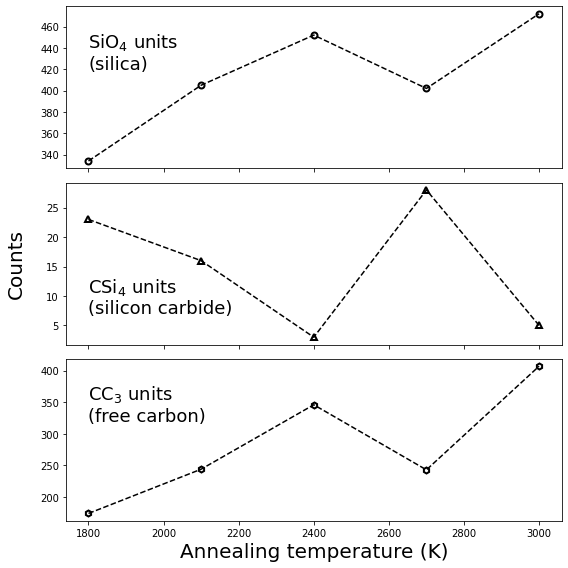

In [8]:
tanneal = [1800, 2100, 2400, 2700, 3000]
SiO4 = [334, 405, 452, 402, 472]
SiC  = [23, 16, 3, 28, 5]
freeCarbon = [174, 244, 346, 243, 407]

fig, axs = plt.subplots(3, figsize=(8, 8), sharex=True)
axs[0].plot(tanneal, SiO4, c="k", ls="--", marker="o", fillstyle="none", mew=2)
axs[0].annotate("SiO$_4$ units \n(silica)", (1800, 420), fontsize=18)
axs[1].plot(tanneal, SiC, c="k", ls="--", marker="^", fillstyle="none", mew=2)
axs[1].annotate("CSi$_4$ units \n(silicon carbide)", (1800, 7), fontsize=18)
axs[2].plot(tanneal, freeCarbon, c="k", ls="--", marker="h", fillstyle="none", mew=2)
axs[2].annotate("CC$_3$ units \n(free carbon)", (1800, 320), fontsize=18)

axs[2].set_xlabel("Annealing temperature (K)", fontsize=20);
axs[1].set_ylabel("Counts", labelpad=20, fontsize=20);
fig.tight_layout()
fig.savefig("MicrostructureEvolution.png", transparent=True, dpi=150)




# Relative occurence of various Si-X-Y building blocks

SiO$_4$ / SiO$_3$C / SiO$_2$C$_2$ / SiO$_1$C$_3$ / SiC$_4$ 

- MK_PMS = (1., 0.27547086, 0.08478344, 0.01936132, 0.02713207)
- S_604  = (1., 0.4045269,  0.15314372, 0.02592717, 0.02024462)
- SPR_212 = (1., 0.32044247, 0.14804881, 0.0547751,  0.1292725)

In [9]:
sim_speed =  ["fast", "slow"]
samples = ["MK_PMS",  "S_604",  "SPR_212", "SPR_684" ]


sample = "MK_PMS"
speed  = "slow"

BONDS  = []
BLOCKS = []
subtract_from_counter = 0
for counter in range(1, 11):
    print(counter)
    try:
        bonds  = {}
        blocks = {}
        atoms = ase.io.read("%s/%s/%i/out.data" %(speed, sample, counter), 
                            Z_of_type = {1:14, 2:8, 3:6}, 
                            style="atomic", format="lammps-data") 
        #print("%s/%s/%i/out.data" %(speed, sample, counter))

        NL = ST.get_ase_neighborlist(atoms, cutoff={("Si","Si"):2.5, 
                                                    ("Si","O") : 2,
                                                    ("Si","C"): 2.2,
                                                    ("C","O") : 1.8,
                                                    ("C","C") : 1.6,
                                                    ("O","O") : 1.8,
                                                    })
    
    
        for i in range(len(atoms)):
            X = atoms[i].symbol
            block = {"Si":0, "O":0, "C":0}
            for j in NL[i]["i"]:
                Y = atoms[j].symbol
                bond = [X, Y]
                block[Y] += 1
                bond.sort()
                bond = bond[0]+bond[1]
                if bond not in bonds:
                    bonds[bond] = 0
                bonds[bond] += 1
        
    
            B = X
            for Y in ["Si", "O", "C"]:
                if block[Y]:
                    B += "-"+Y+"%i" % block[Y]    
            
            if B not in blocks:
                blocks[B] = 0
            blocks[B] += 1

        blocks = {k: v for k, v in sorted(blocks.items(), key=lambda item: -item[1])}
        bonds = {k: v for k, v in sorted(bonds.items(), key=lambda item: -item[1])}
        BONDS.append(bonds)
        BLOCKS.append(blocks)
        
    except:
        print("issue")
        subtract_from_counter = +1

counter -= subtract_from_counter
        
keys = {"blocks": [], "bonds":[]} 
for blocks in BLOCKS:
    for key in blocks.keys():
        if key not in keys:
            keys["blocks"].append(key)

for blocks in BLOCKS:
    for key in keys["blocks"]:
        if key not in blocks.keys():
            blocks[key]=0
    
for bonds in BONDS:
    for key in bonds.keys():
        if key not in keys:
            keys["bonds"].append(key)
            


1
issue
2
issue
3
issue
4
issue
5
issue
6
issue
7
issue
8
issue
9
issue
10
issue


In [10]:
xticklabels = list(BLOCKS[0].keys())
x = np.arange(0, len(xticklabels), dtype=float)
plt.figure(figsize=(8, 5))
dx = 0.1
x -= 0.4
for block in BLOCKS:
    y = np.array(list(block.values())) / block["Si-O4"]
    plt.bar(x, y, width=0.1)
    x += 0.1
    
x = np.arange(0, len(xticklabels), dtype=float)
plt.xticks(x, xticklabels, rotation=60, fontsize=20);
plt.xlim([-1, 14]);
plt.yticks(fontsize=20)
plt.ylabel("Relative occurence", fontsize=24);
plt.savefig("%s.%s.all.png" %(sample, speed), dpi=150)

IndexError: list index out of range

[1.         0.094882   0.01340208 0.00559973 0.00801149]


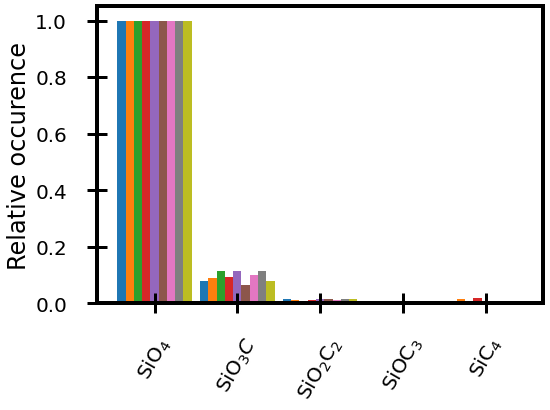

In [82]:
x = ["Si-O4", "Si-O3-C1", "Si-O2-C2", "Si-O1-C3", "Si-C4"]
ticks = ["SiO$_4$", "SiO$_3C$", "SiO$_2$C$_2$", "SiOC$_3$", "SiC$_4$"]
Y = 0
plt.figure(figsize=(8, 5))
dx = -0.4
for blocks in BLOCKS:
    y = []
    for key in x:
        y.append(blocks[key]/blocks["Si-O4"])
    plt.bar(np.arange(len(x))+dx, y, width=0.1)
    dx += 0.1
    Y += np.array(y)
plt.xticks(np.arange(len(x)), ticks, rotation=60, fontsize=20);
plt.yticks(fontsize=20);
print(Y/len(BLOCKS))
plt.ylabel("Relative occurence", fontsize=24);
plt.savefig("%s.%s.Si-blocks.png" %(sample, speed), dpi=150)

[1.         0.13221665]


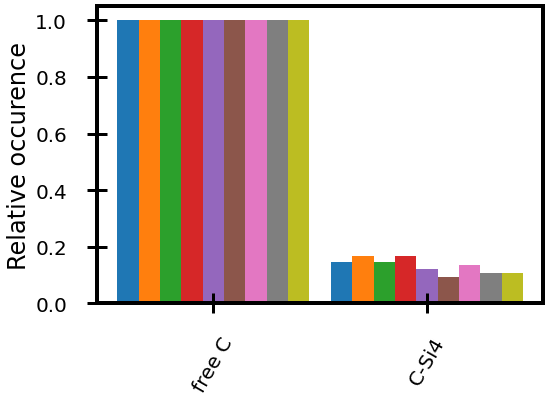

In [84]:
x = ["C-C3", "C-Si4", ]
ticks = ["free C", "C-Si4" ]
Y = 0
plt.figure(figsize=(8, 5))
dx = -0.4
for blocks in BLOCKS:
    y = []
    for key in x:
        y.append(blocks[key]/blocks["C-C3"])
    plt.bar(np.arange(len(x))+dx, y, width=0.1)
    dx += 0.1
    Y += np.array(y)
plt.xticks(np.arange(len(x)), ticks, rotation=60, fontsize=20);
plt.yticks(fontsize=20);
print(Y/len(BLOCKS))
plt.ylabel("Relative occurence", fontsize=24);
plt.savefig("%s.%s.C-blocks.png" %(sample, speed), dpi=150)

In [ ]:
bonds

{'OSi': 8314, 'CSi': 1998, 'CC': 1920, 'SiSi': 172, 'CO': 4}